In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.feynnet

In [3]:
use_signal = [ i for i, m in enumerate(module.feynnet_signal_list) if m in module.signal_list ]
training_signal = [ i for i, m in enumerate(module.feynnet_signal_list) if m in module.full_signal_list ] 

In [4]:
signal = ObjIter([Tree(f, report=False, altfile='test_{base}') for f in tqdm(module.feynnet_signal_list)])

100%|██████████| 33/33 [01:21<00:00,  2.48s/it]


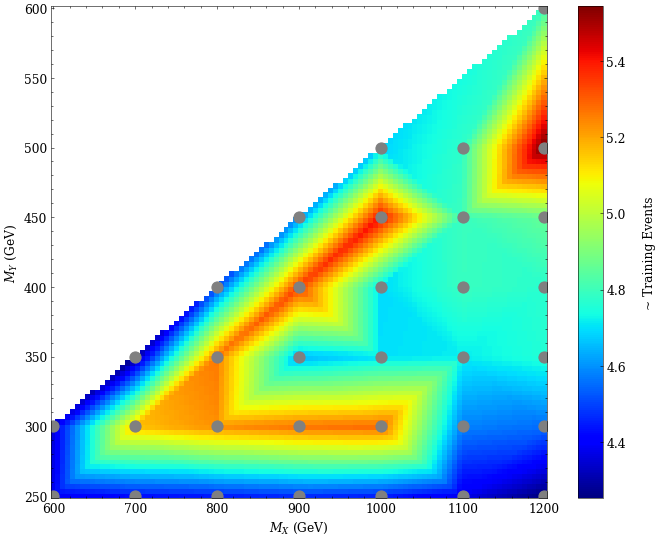

In [9]:
fig, ax = study.get_figax(size=(10,8))

study.mxmy_phase(
    signal,
    label=signal.mass.list,
    zlabel='~ Training Events',
    # efficiency=True,

    f_var=lambda t: np.log10((0.8/0.2)*ak.sum(t.nfound_select==8)),
    g_cmap='jet',

    xlabel='$M_X$ (GeV)',
    ylabel='$M_Y$ (GeV)',

    # xlim=(550,1250),
    # ylim=(200,650),
    # zlim=np.linspace(3,6,11),

    figax=(fig,ax)
)

# graph_array(training_mx, training_my, figax=(fig,ax), g_color='red', g_ls='none', xlim=None, ylim=None)



In [5]:
bkg = ObjIter([Tree(module.Run2_UL18.QCD_B_List, altfile='test_{base}')])


100%|██████████| 16/16 [00:11<00:00,  1.38it/s]


In [14]:
import awkward0 as ak0

ranker = ak0.load('/eos/uscms/store/user/ekoenig/weaver/models/exp_feynnet_paper/feynnet_8b/20230421_ranger_lr0.0047_batch1024/predict_output/NMSSM_XYY_YToHH_8b_MX_600_MY_250_test_ntuple.root.awkd')

In [15]:
ranker['maxcomb']

array([[0., 4., 2., ..., 7., 3., 5.],
       [0., 6., 3., ..., 2., 4., 7.],
       [0., 5., 4., ..., 2., 3., 7.],
       ...,
       [0., 4., 6., ..., 3., 2., 5.],
       [0., 4., 1., ..., 5., 6., 7.],
       [0., 6., 2., ..., 5., 3., 4.]], dtype=float32)

In [67]:
len(signal)

33

In [66]:
signal.apply(lambda t : print(f"MX_{t.mx}_MY_{t.my}"))

MX_600_MY_250
MX_600_MY_300
MX_700_MY_250
MX_700_MY_300
MX_700_MY_350
MX_800_MY_250
MX_800_MY_300
MX_800_MY_350
MX_800_MY_400
MX_900_MY_250
MX_900_MY_300
MX_900_MY_350
MX_900_MY_400
MX_900_MY_450
MX_1000_MY_250
MX_1000_MY_300
MX_1000_MY_350
MX_1000_MY_400
MX_1000_MY_450
MX_1000_MY_500
MX_1100_MY_250
MX_1100_MY_300
MX_1100_MY_350
MX_1100_MY_400
MX_1100_MY_450
MX_1100_MY_500
MX_1200_MY_250
MX_1200_MY_300
MX_1200_MY_350
MX_1200_MY_400
MX_1200_MY_450
MX_1200_MY_500
MX_1200_MY_600


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]

In [6]:
model = eightb.models.feynnet_sig_33sig
(signal + bkg).apply( lambda t : eightb.load_yy_quadh_ranker(t, model.storage), report=True )

100%|██████████| 34/34 [15:17<00:00, 26.99s/it]


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]

In [7]:
def fully_reconstructed(t):
    h_b_ids = [ t[f'{quark}_signalId'] // 2 for quark in eightb.quarklist ]
    y_h_ids = [ ak.where(h_b1_id == h_b2_id, h_b1_id, -1) // 2 for h_b1_id, h_b2_id in zip(h_b_ids[::2], h_b_ids[1::2]) ]
    y1_id, y2_id = [ ak.where(y_h1_id == y_h2_id, y_h1_id, -1) // 2 for y_h1_id, y_h2_id in zip(y_h_ids[::2], y_h_ids[1::2]) ]
    reco_id = ak.where(y1_id == y2_id, y1_id, -1)
    t.extend(
        reco_id = reco_id
    )
(signal).apply(fully_reconstructed)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]

In [8]:
eightb_signal = signal.apply(EventFilter('all_eightb', filter=lambda t : t.nfound_select==8))
partial_signal = signal.apply(EventFilter('partial_eightb', filter=lambda t : t.nfound_select< 8))

In [22]:
unique_mx = np.unique(eightb_signal.mx.npy)
unique_my = np.unique(eightb_signal.my.npy)

In [51]:
def n_higgs_reco(t):
    return ak.sum(t.higgs_signalId > -1, axis=1)

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

x_mean=16.000
x_std=9.522
x_min=0.000
x_max=32.000
y_mean=0.683
y_std=0.184
y_min=0.355
y_max=0.994
x_sum=528.000
y_sum=22.538
area=21.665
ndf=33.000


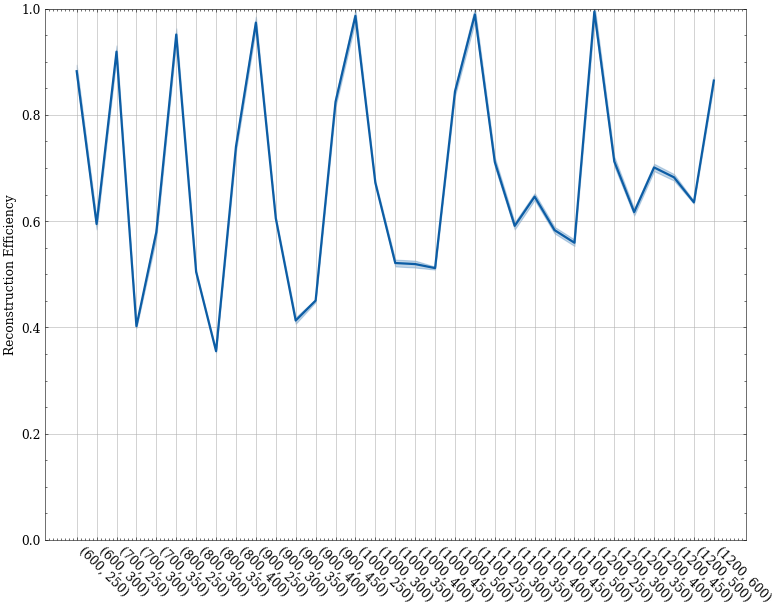

In [41]:
fig, ax = study.get_figax(size=(10,8))

study.statsplot(
    eightb_signal,
    label=signal.mass.list,
    varlist=['reco_id'],
    xlabels=['Reconstruction Efficiency'],
    efficiency=True,

    stat=lambda h:h.histo[-1],
    stat_err=lambda h:h.error[-1],
    g_grid=True,

    g_exe=lambda graph, **kwargs: print( f'{graph.stats:0.3f}'),
    g_ylim=(0,1),
    # g_g_label=f'MY={my}',
    # g_xlabel='MX',
    g_legend=True,
    figax=(fig,ax)
)

In [61]:
from utils.ak_tools import ak_argavg

In [71]:
eightb_signal_eff = eightb_signal.apply( lambda t : ak.mean(t.reco_id == 0) ).npy
extrema_signal = [eightb_signal_eff .argmin(), ak_argavg(eightb_signal_eff), eightb_signal_eff.argmax()]
eightb_signal_eff[extrema_signal]

array([0.35536648, 0.68252292, 0.99439588])

In [73]:
extrema_signal

[7, 30, 26]

100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


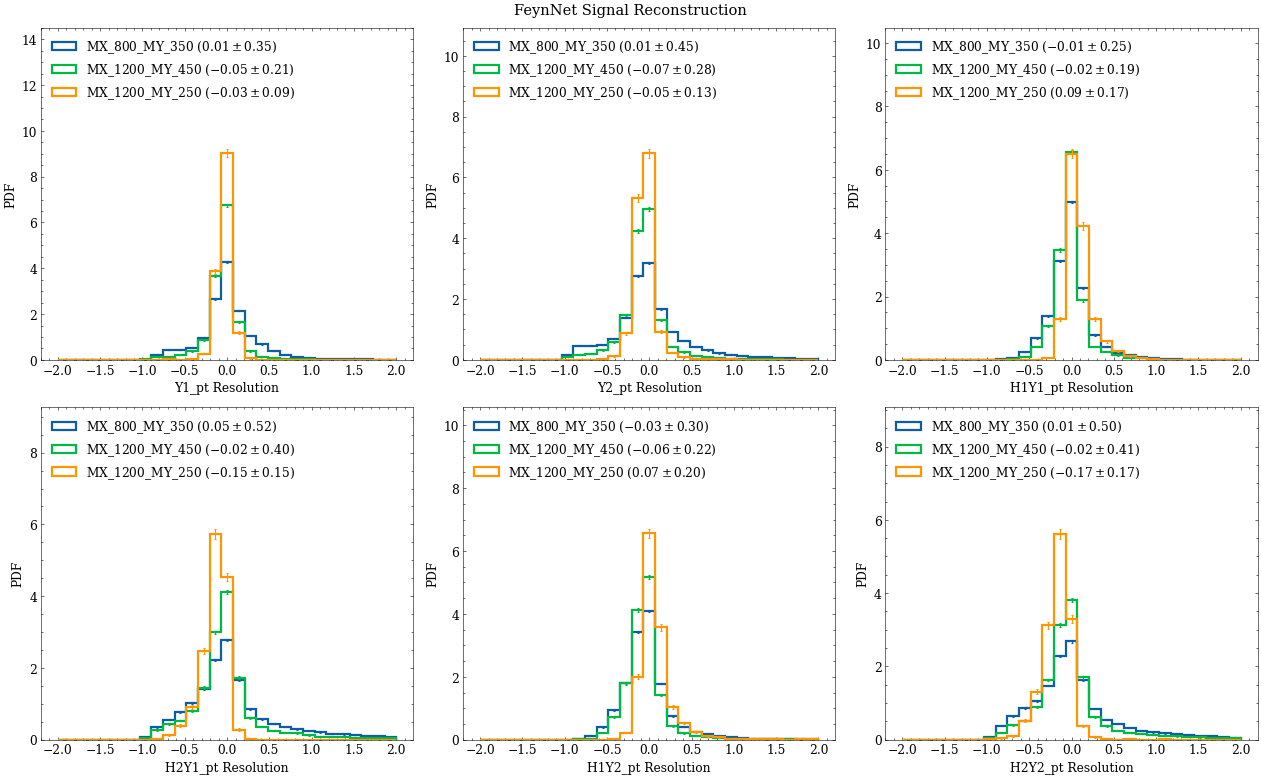

In [66]:
class gen_res(ObjTransform):
    def __init__(self, kin):
        self.kin = kin
    @property
    def xlabel(self): return f'{self.kin} Resolution'
    @property
    def bins(self): return (-2,2,30)
    def __call__(self, t):
        if self.kin is None: return
        return (t[self.kin]-t[f'gen_{self.kin}'])/t[f'gen_{self.kin}']

study.quick(
    eightb_signal[extrema_signal],
    legend=True,
    h_label_stat='${stats.mean:0.2f}\pm{stats.stdv:0.2f}$',
    varlist=[ gen_res(f'{res}_pt') for res in ['Y1','Y2','H1Y1','H2Y1','H1Y2','H2Y2']],
    suptitle='FeynNet Signal Reconstruction',
    h_restrict=True,
    lumi=None,
    density=True,
)

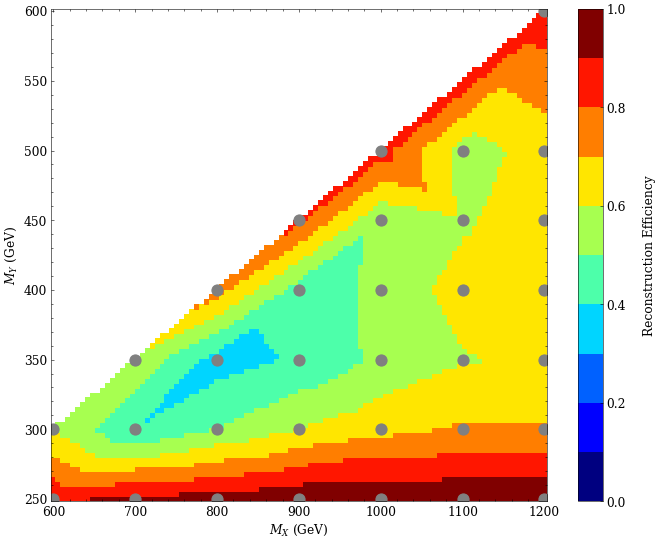

In [ ]:
fig, ax = study.get_figax(size=(10,8))

study.mxmy_phase(
    eightb_signal,
    label=signal.mass.list,
    zlabel='Reconstruction Efficiency',
    efficiency=True,

    f_var=lambda t: ak.mean(t.reco_id==0),
    g_cmap='jet',

    xlabel='$M_X$ (GeV)',
    ylabel='$M_Y$ (GeV)',

    # xlim=(550,1250),
    # ylim=(200,650),
    zlim=np.linspace(0,1,11),

    figax=(fig,ax)
)

training_mx = eightb_signal[training_signal].mx
training_my = eightb_signal[training_signal].my

# graph_array(training_mx, training_my, figax=(fig,ax), g_color='red', g_ls='none', xlim=None, ylim=None)



100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


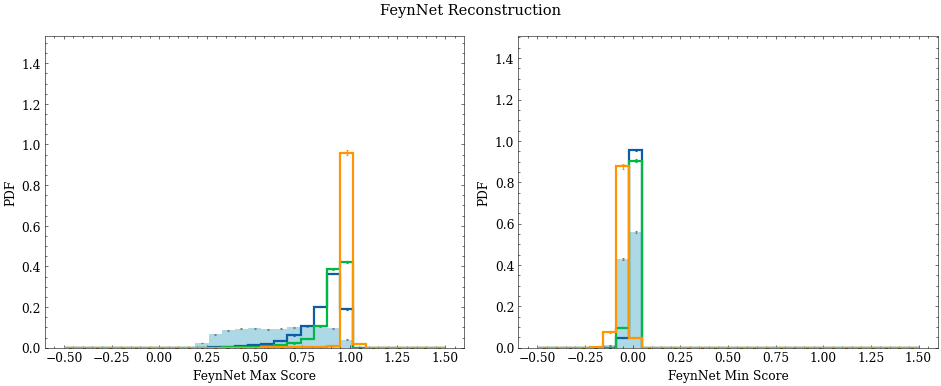

In [72]:
study.quick(
    eightb_signal[extrema_signal]+bkg,
    # legend=True,
    h_label_stat=None,
    varlist=['yy_quadh_score','yy_quadh_minscore'],
    xlabels=['FeynNet Max Score','FeynNet Min Score'],
    binlist=[(-0.5,1.5,30)]*2,
    suptitle='FeynNet Reconstruction',
    efficiency=True,
    lumi=None,
    # **study.auroc,
)

In [68]:
varinfo.X_m =   dict(bins=(400,2000,30), xlabel='$M_{X}$ (GeV)')
varinfo.Y1_m =  dict(bins=(100,1000,30), xlabel='Leading Y Boson Mass (GeV)')
varinfo.Y2_m =  dict(bins=(100,1000,30), xlabel='Subleading Y Boson Mass (GeV)')
varinfo.H1Y1_m =   dict(bins=(0,300,30), xlabel='Leading Y\'s Leading Higgs Boson Mass (GeV)')
varinfo.H2Y1_m =   dict(bins=(0,300,30), xlabel='Leading Y\'s Subleading Higgs Boson Mass (GeV)')
varinfo.H1Y2_m =   dict(bins=(0,300,30), xlabel='Subleading Y\'s Leading Higgs Boson Mass (GeV)')
varinfo.H2Y2_m =   dict(bins=(0,300,30), xlabel='Subleading Y\'s Subleading Higgs Boson Mass (GeV)')


100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


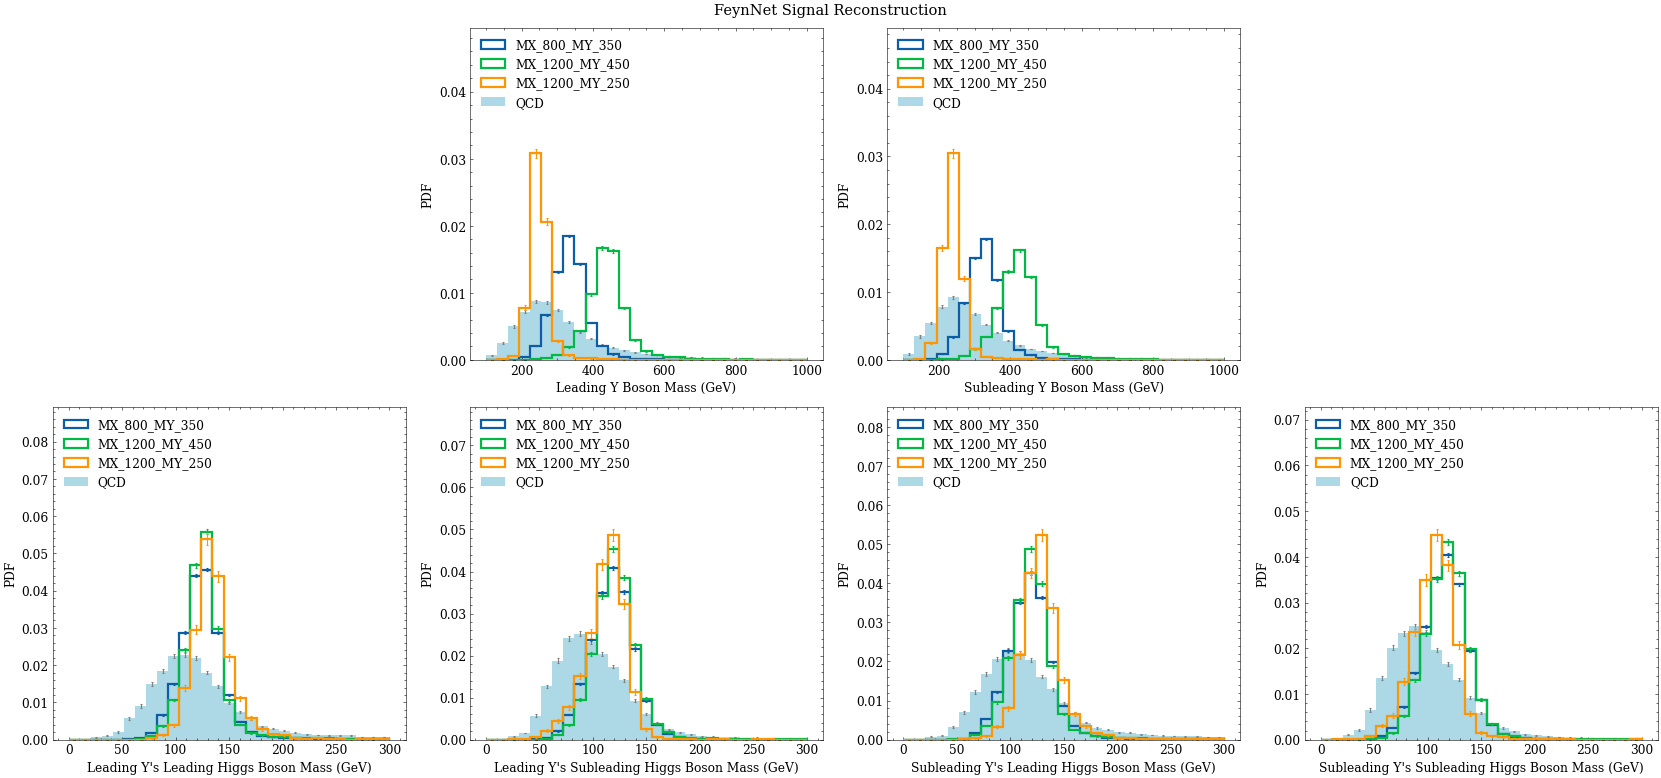

In [69]:
study.quick(
    eightb_signal[extrema_signal]+bkg,
    legend=True,
    h_label_stat=None,
    varlist=[None,'Y1_m','Y2_m',None,'H1Y1_m','H2Y1_m','H1Y2_m','H2Y2_m'],
    suptitle='FeynNet Signal Reconstruction',
    lumi=None,
    density=True,
)

In [36]:
eightb_signal.apply(lambda t : t.extend(norm_scale=1/(len(t) * t.scale)))
bkg.apply(lambda t : t.extend(norm_scale=ak.ones_like(t.scale)))


[None]

100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


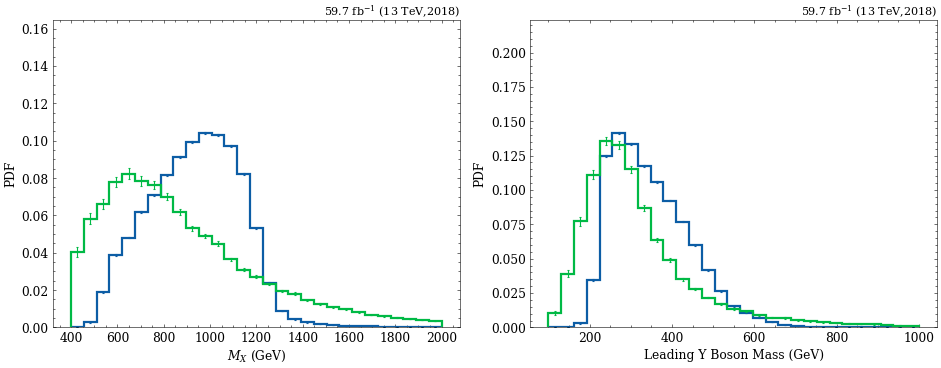

In [37]:
study.quick_region(
    eightb_signal,bkg,
    scale=lambda t : t.norm_scale,
    varlist=['X_m','Y1_m'],
    efficiency=True,

)